# Mongolian Food Classifier

## Package Installation and Imports

In [1]:
!pip install -Uqq fastai --upgrade
!pip install -Uqq fastcore --upgrade
!pip install -Uqq duckduckgo_search --upgrade

import fastai
import fastcore
print('Fast.ai version:', fastai.__version__)
print('Fastcore version:', fastcore.__version__)

from fastai.vision.all import *
from fastai.vision.widgets import *
from duckduckgo_search import DDGS
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    with DDGS() as ddgs:
        search_results = ddgs.images(keywords=term)
        image_urls = [result.get("image") for result in search_results][:max_images]
        return L(image_urls)

Fast.ai version: 2.7.18
Fastcore version: 1.7.29


## Gather Training Data

In [2]:
food_types = 'buuz', 'khuushuur', 'tsuivan', 'olivier_salad'
path = Path('mongolian_foods')

if not path.exists():
    path.mkdir()
    for o in food_types:
        print(f'Finding images for {o}')
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        urls = search_images(f'mongolian {o} food', max_images=50)
        download_images(dest, urls=urls)

Finding images for buuz
Searching for 'mongolian buuz food'
Finding images for khuushuur
Searching for 'mongolian khuushuur food'
Finding images for tsuivan
Searching for 'mongolian tsuivan food'
Finding images for olivier_salad
Searching for 'mongolian olivier_salad food'


In [3]:
fns = get_image_files(path)
fns

failed = verify_images(fns)
failed

failed.map(Path.unlink)

(#4) [None,None,None,None]

## Build Data Loader


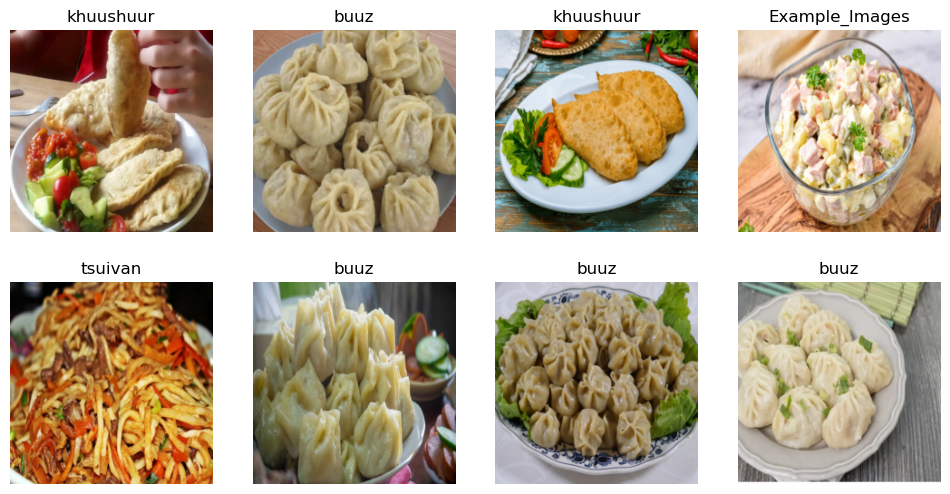

In [13]:
foods = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms()
)

dls = foods.dataloaders(path)
dls.valid.show_batch(max_n=8, nrows=2)

## Train Model Using Transfer Learning


In [14]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(6)

\\?\C:\Users\User\AppData\Roaming\jupyterlab-desktop\jlab_server\Lib\site-packages\fastai\vision\learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


epoch,train_loss,valid_loss,error_rate,time
0,3.438413,2.434649,0.678571,00:07


epoch,train_loss,valid_loss,error_rate,time
0,3.093958,2.186954,0.678571,00:08
1,3.100253,1.629792,0.571429,00:08
2,2.854558,1.037096,0.392857,00:08
3,2.636937,0.767111,0.285714,00:08
4,2.363431,0.665195,0.214286,00:08
5,2.181004,0.636654,0.214286,00:08


## Evaluate Initial Model


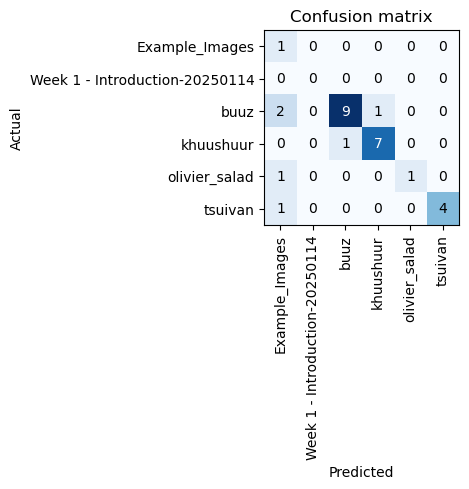

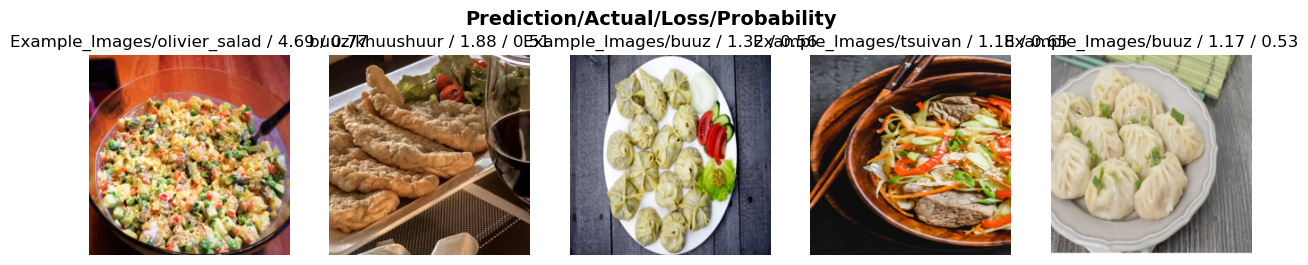

In [15]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.plot_top_losses(5, nrows=1)

## Clean Dataset Using Image Cleaner


In [16]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [17]:
for idx in cleaner.delete():
    cleaner.fns[idx].unlink()

for idx,cat in cleaner.change():
    shutil.move(str(cleaner.fns[idx]), path/cat)

## Retrain Model with Cleaned Data


In [18]:
foods = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms()
)

dls = foods.dataloaders(path)
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

\\?\C:\Users\User\AppData\Roaming\jupyterlab-desktop\jlab_server\Lib\site-packages\fastai\vision\learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


epoch,train_loss,valid_loss,error_rate,time
0,3.051969,3.340081,0.750000,00:07


epoch,train_loss,valid_loss,error_rate,time
0,3.368531,2.877842,0.750000,00:08
1,3.207312,2.029989,0.678571,00:08
2,2.879387,1.580045,0.571429,00:08
3,2.503869,1.369165,0.464286,00:08


## Final Model Evaluation


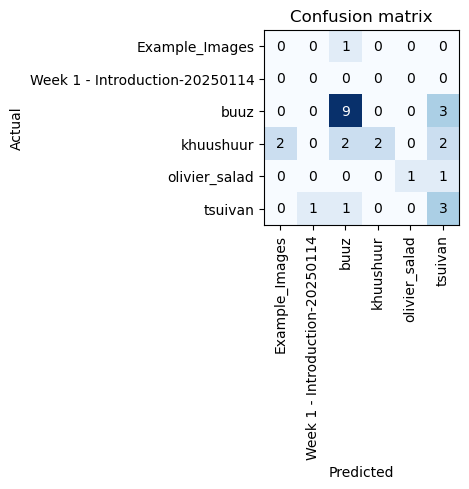

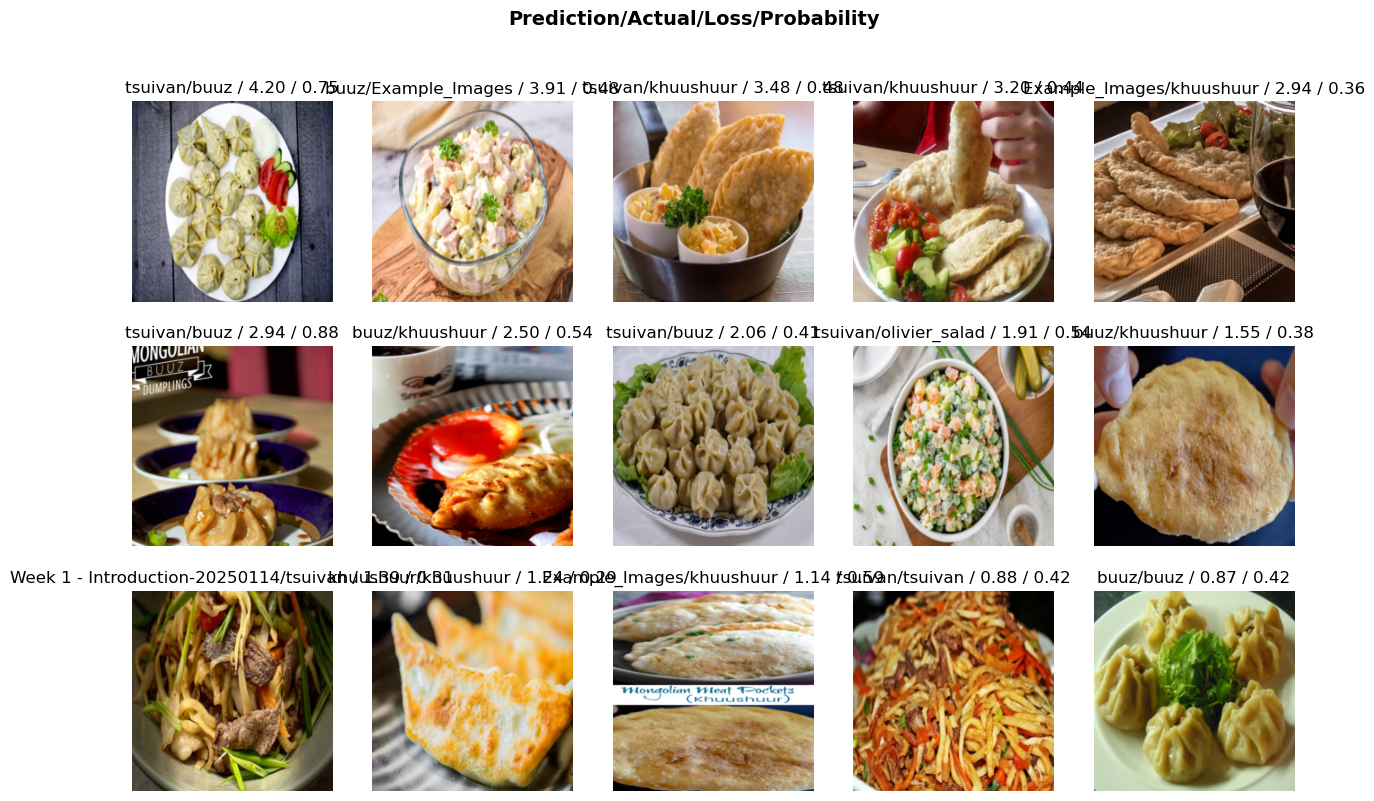

In [19]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.plot_top_losses(15, nrows=3)

## Export Model

In [20]:
learn.export('mongolian_food_classifier.pkl')

path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('mongolian_food_classifier.pkl')]